In [1]:
import numpy as np
import pickle
from os.path import abspath, isfile
from IPython.display import display, Markdown
from activations import Logistic, Linear
from losses import SquaredError, BinaryCrossEntropy
from utils import load_model, plot_errors

In [2]:
class Neuron:
    def __init__(self, activation, num_inputs, learning_rate, weights=None, bias=None):

        if not isinstance(activation, (Logistic, Linear)):
            raise ValueError('Unexpected activation function, expected Logistic or Linear.')

        if num_inputs < 1:
            raise ValueError('The number of inputs must be greater than 0.')

        if learning_rate < 10e-10:
            raise ValueError('The learning rate has to be greater than 0.')

        self._weights = weights if weights is not None else np.random.randn(num_inputs)
        self._bias = bias if bias is not None else np.random.randn()

        self._activation = activation
        self._learning_rate = learning_rate
        self._delta = None
        self._inp = None
        self._out = None

    def activate(self, inp):
        return self._activation.activate(inp)
        
    def backprop(self, error):
        # calculate the per-neuron delta bases on last output and the backpropagated error
        self._delta = error * self._out * (1 - self._out)
        # calculate the per-neuron error to propagate backwards and return it
        ret = self._delta * np.array(self._weights)
        # update the biases
        self._bias -= self._delta * self._learning_rate
        # update the weights
        self._weights -= self._learning_rate * self._inp * self._delta
        return ret

    def calculate(self, inp):
        # store input for backprop
        self._inp = np.array(inp)
        # pass the input through the activation function for each neuron
        self._out = self.activate(np.dot(inp, self._weights) + self._bias)
        return self._out

    @property
    def bias(self):
        return self._bias

    @bias.setter
    def bias(self, bias):
        self._bias = bias

    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, weights):
        self._weights = weights


class FullyConnectedLayer:

    def __init__(self, num_neurons, activation, num_inputs, learning_rate, weights=None, biases=None):

        self._num_neurons = num_neurons
        self._num_inputs = num_inputs
        self._activation = activation

        self._neurons = [
            Neuron(
                activation=activation,
                num_inputs=num_inputs,
                learning_rate=learning_rate,
                weights=weights[neur_idx] if weights is not None else weights,
                bias=biases[neur_idx] if biases is not None else biases
            )
            for neur_idx in range(num_neurons)
        ]

    def backprop(self, error):
        # calculate the error that propagates through each neuron in the layer
        out = np.array([neuron.backprop(error[neur_idx]) for neur_idx, neuron in enumerate(self._neurons)])
        # sum the error before passing it to the next layer
        return np.sum(out, axis=0)

    def calculate(self, inp):
        return [neuron.calculate(inp) for neuron in self._neurons]

    @property
    def biases(self):
        return np.array([neuron.bias for neuron in self._neurons])

    @biases.setter
    def biases(self, biases):
        for neur_idx, neuron in enumerate(self._neurons):
            neuron.bias = biases[neur_idx]

    @property
    def weights(self):
        return np.array([neuron.weights for neuron in self._neurons])

    @weights.setter
    def weights(self, weights):
        for neur_idx, neuron in enumerate(self._neurons):
            neuron.weights = weights[neur_idx]


class NeuralNetwork:
    def __init__(self, num_layers, num_neurons, activations, num_inputs, loss, learning_rate, weights=None,
                 biases=None):

        if not isinstance(loss, (SquaredError, BinaryCrossEntropy)):
            raise ValueError('Unexpected loss function, expected instance of SquaredError or BinaryCrossEntropy')

        if num_layers < 1:
            raise ValueError('The minimum number of layers is one.')

        if not isinstance(num_neurons, (list, np.ndarray)):
            raise ValueError('Unexpected number of neurons, expected list of neurons by layer.')

        if len(num_neurons) != num_layers:
            raise ValueError(f'The neurons list should have {num_layers} elements.')

        if not isinstance(activations, (list, np.ndarray)):
            activations = [activations for _ in range(num_layers)]

        if len(activations) != num_layers:
            raise ValueError(f'The activations list should have {num_layers} activation functions.')

        self.layers = [
            FullyConnectedLayer(
                num_neurons=num_neurons[layer_idx],
                activation=activations[layer_idx],
                num_inputs=num_inputs if layer_idx == 0 else num_neurons[layer_idx - 1],
                learning_rate=learning_rate,
                weights=weights[layer_idx] if weights is not None else weights,
                biases=biases[layer_idx] if biases is not None else biases
            )
            for layer_idx in range(num_layers)
        ]

        self._loss = loss

    def calculate(self, inp):
        # pass the input through each layer to get the final prediction
        for layer in self.layers:
            inp = layer.calculate(inp)
        return np.array(inp)

    def calculateloss(self, inp, out):
        # get the prediction for each input
        preds = np.array([self.calculate(i) for i in inp])
        # return the total error based on the predictions and expected output
        return self._loss.error(preds, out) / out.shape[0]

    def backprop(self, inp, out):
        # get the initial prediction
        pred = self.calculate(inp)
        # calculate the derivative of the error of that prediction w.r.t. the output
        error = self._loss.prime(pred, out)
        # pass the error through each layer backwards to calculate the error as it propagates backwards
        for i, layer in reversed(list(enumerate(self.layers))):
            error = layer.backprop(error)

    @property
    def biases(self):
        return np.array([layer.biases for layer in self.layers])

    @biases.setter
    def biases(self, biases):
        for layer_idx, layer in enumerate(self.layers):
            layer.biases = biases[layer_idx]

    @property
    def weights(self):
        return np.array([layer.weights for layer in self.layers])

    @weights.setter
    def weights(self, weights):
        for layer_idx, layer in enumerate(self.layers):
            layer.weights = weights[layer_idx]

    # load weights from <filename>
    def load_weights(self, filename):
        if not filename.endswith('.pkl'):
            filename += '.pkl'

        filename = abspath(filename)

        if not isfile(filename):
            raise ValueError(f'{filename} is not a valid filepath.')

        with open(filename, 'rb') as f:
            self.weights = pickle.load(f)

    def save_weights(self, filename):
        if not filename.endswith('.pkl'):
            filename += '.pkl'

        filename = abspath(filename)

        with open(filename, 'wb') as f:
            pickle.dump(self.weights, f)

    # save a model to <filename>
    def save(self, filename):
        if not filename.endswith('.pkl'):
            filename += '.pkl'

        filename = abspath(filename)

        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def train(self, inp, out, epochs=10000, ret_error=False):
        errors = [self.calculateloss(inp, out)]
        # run backprop for each input a total of <epoch> times
        for _ in range(epochs):
            for i, o in zip(inp, out):
                self.backprop(i, o)
            if ret_error:
                errors.append(self.calculateloss(inp, out))
                
        if ret_error: return errors

### XOR

In [3]:
xor_inputs = np.array([
    [0, 0], [0, 1],
    [1, 0], [1, 1]
])
xor_outputs = np.array([[0], [1], [1], [0]])

lrs = [.01, .05, .1, .5, 1, 5, 10, 50]
xor_errors = {}
for lr in lrs:
    np.random.seed(0)
    xor_nn = NeuralNetwork(2, [2, 1], Logistic(), 2, BinaryCrossEntropy(), lr)
    xor_errors[lr] = xor_nn.train(xor_inputs, xor_outputs, epochs=10000, ret_error=True)

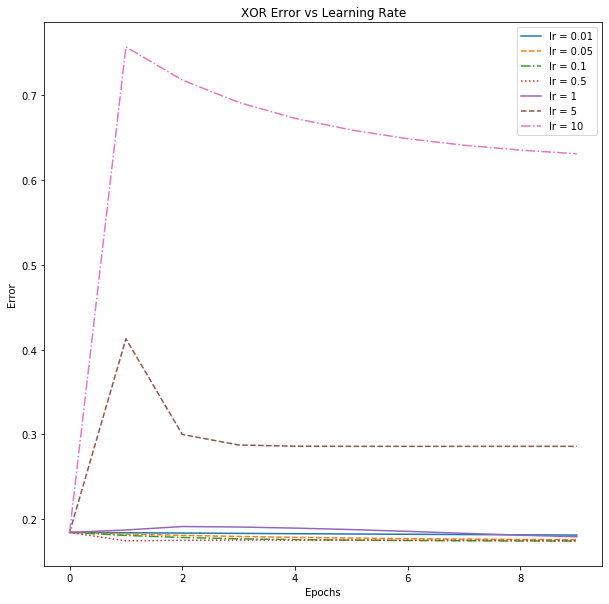

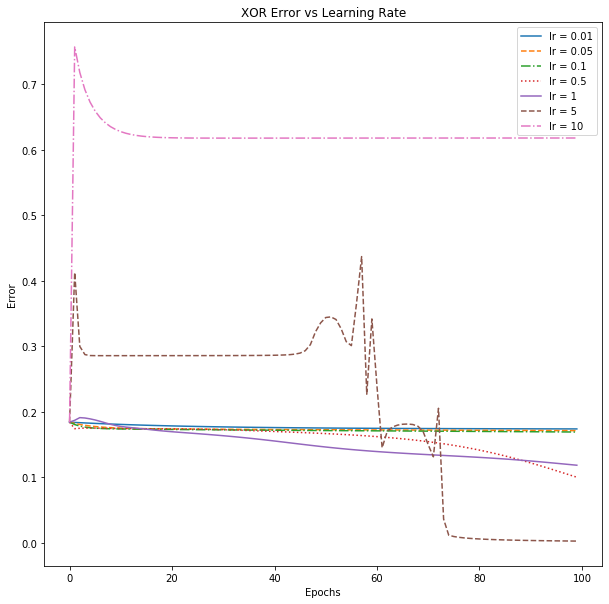

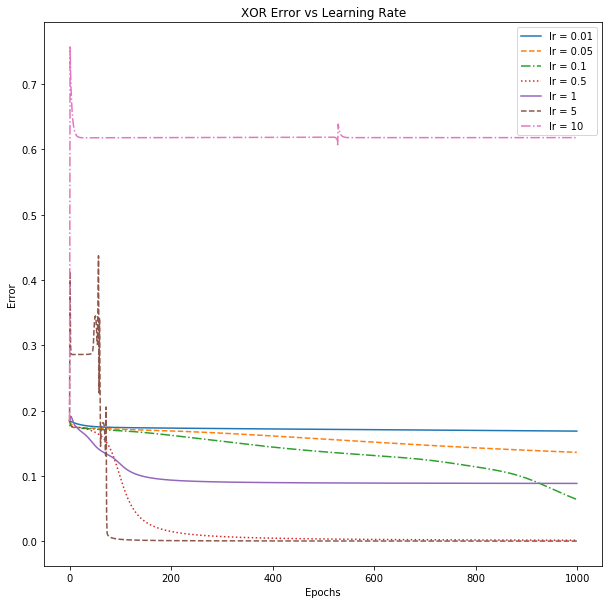

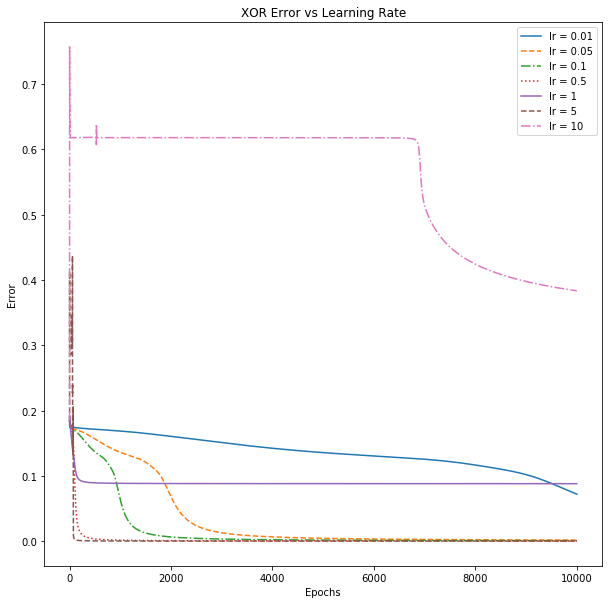

In [4]:
plot_errors(xor_errors, lrs[:-1], 'XOR Error vs Learning Rate', n=10)
plot_errors(xor_errors, lrs[:-1], 'XOR Error vs Learning Rate', n=100)
plot_errors(xor_errors, lrs[:-1], 'XOR Error vs Learning Rate', n=1000)
plot_errors(xor_errors, lrs[:-1], 'XOR Error vs Learning Rate', n=10000)

### AND

In [5]:
and_inputs = np.array([
    [0, 0], [0, 1],
    [1, 0], [1, 1]
])
and_outputs = np.array([[0], [0], [0], [1]])
lrs = [.01, .05, .1, .5, 1, 5, 10, 50, 100, 500]
and_errors = {}
for lr in lrs:
    np.random.seed(0)
    and_nn = NeuralNetwork(1, [1], Logistic(), 2, SquaredError(), lr)
    and_errors[lr] = and_nn.train(and_inputs, and_outputs, epochs=10000, ret_error=True)

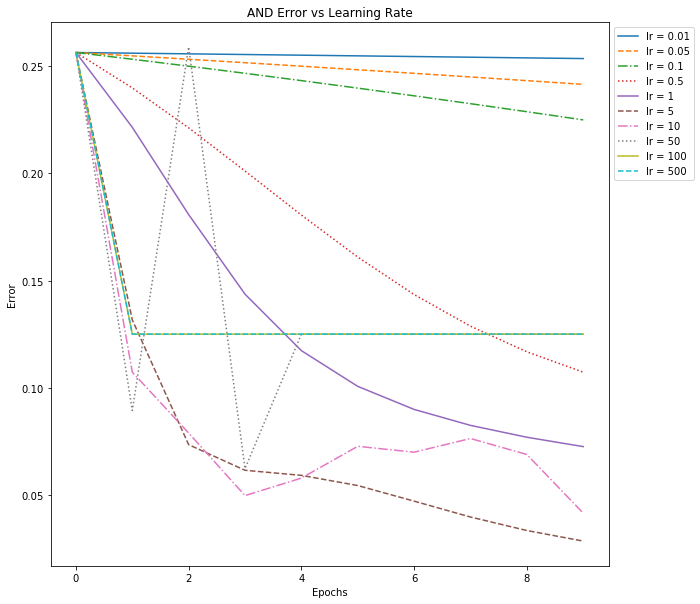

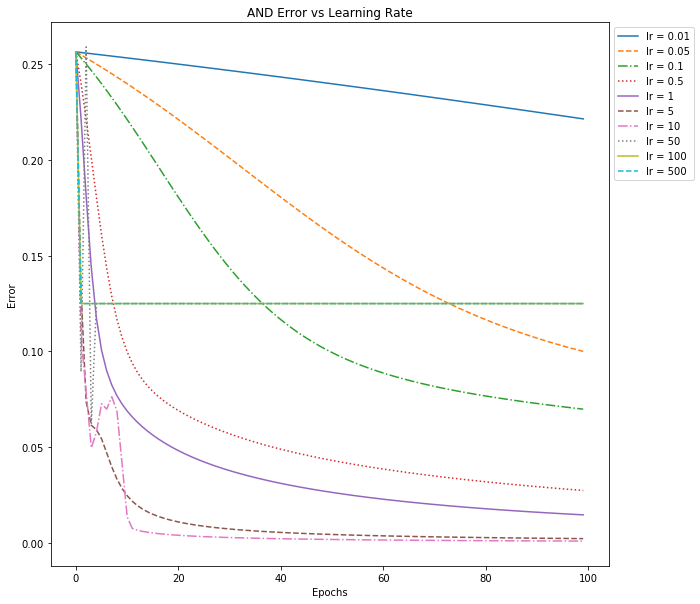

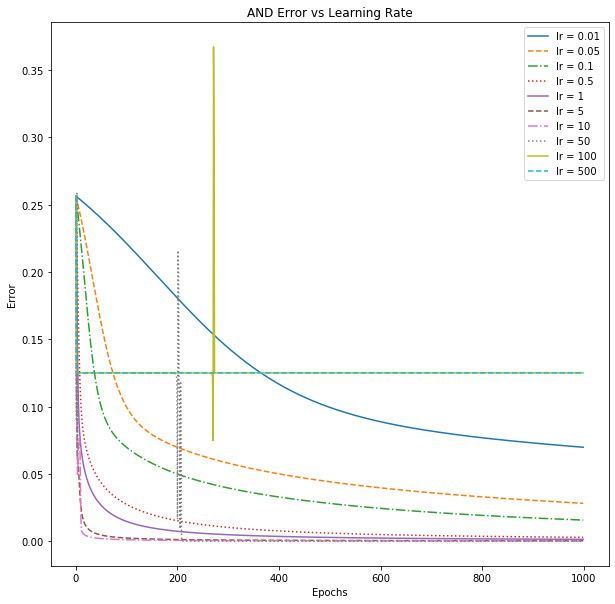

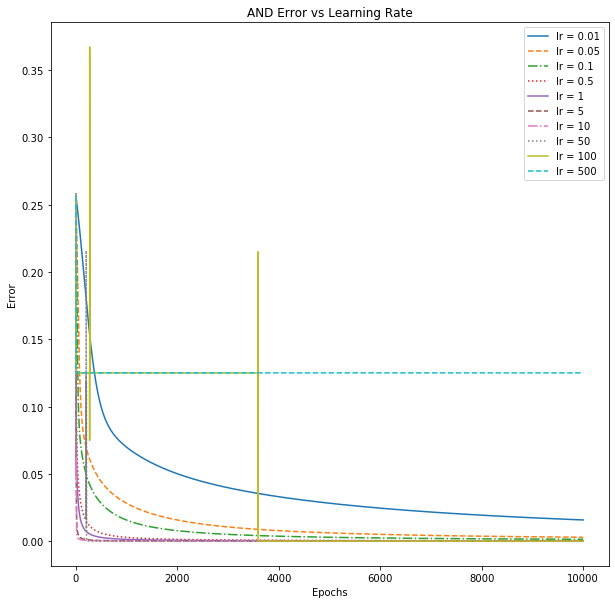

In [6]:
plot_errors(and_errors, lrs, 'AND Error vs Learning Rate', n=10)
plot_errors(and_errors, lrs, 'AND Error vs Learning Rate', n=100)
plot_errors(and_errors, lrs, 'AND Error vs Learning Rate', n=1000)
plot_errors(and_errors, lrs, 'AND Error vs Learning Rate', n=10000)

### Example

In [7]:
example_weights = np.array([[[.15, .2], [.25, .3]], [[.4, .45], [.5, .55]]])
example_input = np.array([[.05, .1]])
example_biases = np.array([[.35, .35], [.6, .6]])
example_target = np.array([[0.01, 0.99]])
example_nn = NeuralNetwork(2, [2, 2], Logistic(), 2, SquaredError(), .5, example_weights, example_biases)
example_nn.backprop(example_input[0], example_target[0])

for i, w in enumerate(example_nn.weights.flatten()):
    display(Markdown(f'$w_{i+1}$: {w}'))

$w_1$: 0.1497807161327628

$w_2$: 0.19956143226552567

$w_3$: 0.24975114363236958

$w_4$: 0.29950228726473915

$w_5$: 0.35891647971788465

$w_6$: 0.4086661860762334

$w_7$: 0.5113012702387375

$w_8$: 0.5613701211079891